In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from astropy.cosmology import FlatwCDM

In [2]:
CSV_PATH = "/Users/pittsburghgraduatestudent/repos/first_paper_blast_webapi/data/DES_BLAST_results.csv"
data = pd.read_csv(CSV_PATH)

In [ ]:
# Define flat ΛCDM cosmology
COSMO = FlatwCDM(H0=70, Om0=0.3, w0=-1.0) # w = -1 is flat ΛCDM

def mu_LCDM(z):
    """Distance modulus μ(z) for flat ΛCDM."""
    z = np.asarray(z, dtype=float)
    return COSMO.distmod(z).value

data["mu_model"] = mu_LCDM(pd.to_numeric(data["zHD"], errors="coerce").to_numpy())

In [4]:
GAMMA = 0.03754   # DES nuisance parameter
MASS_SPLIT = 10.0 # logM* split point

# Choose your host mass column (DES gives HOST_LOGMASS)
is_high_mass = (data["HOST_LOGMASS"] >= MASS_SPLIT).astype(float)

# This is ±γ/2: +γ/2 for high-mass, −γ/2 for low-mass
delta_massstep = GAMMA * (is_high_mass - 0.5)

# Remove it from DES-provided μ
data["mu_noMass"] = data["MU"] - delta_massstep

print(is_high_mass)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
156    1.0
157    1.0
158    1.0
159    0.0
160    0.0
Name: HOST_LOGMASS, Length: 161, dtype: float64


In [ ]:
# -------------------
# Feature matrix (BLAST LOCAL + context)
# -------------------
candidate_features = [
    # BLAST local
    "blast_local_log_mass_50",
    "blast_local_log_sfr_50",
    "blast_local_log_ssfr_50",
    "blast_local_log_age_50",
    #"blast_local_mass_surviving_ratio",
    # optional context
    "blast_host_redshift",
    "blast_host_EBV_MW",
    "zHD",
]

In [6]:
data["residual"] = data["mu_noMass"] - data["mu_model"]

X = data[candidate_features].astype(float)
y = data["residual"].astype(float)
print(data["residual"])
print(X)

print(f"Using {len(candidate_features)} features:", candidate_features)
print(f"Training rows: {len(y)}")

0      0.137994
1     -0.118801
2     -0.112210
3      0.181365
4     -0.251172
         ...   
156   -0.138137
157   -0.051567
158    0.098127
159    0.092139
160    0.216132
Name: residual, Length: 161, dtype: float64
     blast_local_log_mass_50  blast_local_log_sfr_50  blast_local_log_ssfr_50  \
0                   9.546045               -0.928654               -10.538910   
1                   9.997040               -0.925622               -10.907366   
2                   8.708009               -1.692203               -10.417247   
3                   9.096352               -1.163582               -10.298476   
4                   9.538658               -0.617604               -10.123061   
..                       ...                     ...                      ...   
156                 9.657471               -0.971951               -10.667497   
157                 9.700237               -1.329067               -11.086355   
158                 9.319108               -0.75099

In [7]:
# -------------------
# Cross-validation
# -------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def nmad(a):
    med = np.median(a)
    return 1.4826 * np.median(np.abs(a - med))

rmses, nmads, r2s = [], [], []
y_pred_oof = np.empty_like(y, dtype=float)
y_pred_oof[:] = np.nan

model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
)

for tr, te in kf.split(X):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y.iloc[tr], y.iloc[te]
    model.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    yhat = model.predict(Xte)
    y_pred_oof[te] = yhat   # <-- fixed here
    rmses.append(np.sqrt(mean_squared_error(yte, yhat)))
    nmads.append(nmad(yte - yhat))
    r2s.append(r2_score(yte, yhat))

print(f"[XGB 5-fold]  RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f} mag")
print(f"[XGB 5-fold]  NMAD = {np.mean(nmads):.4f} ± {np.std(nmads):.4f} mag")
print(f"[XGB 5-fold]  R²   = {np.mean(r2s):.3f} ± {np.std(r2s):.3f}")

# -------------------
# Fit final model & permutation importance
# -------------------
model.fit(X, y)
perm = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean})
imp = imp.sort_values("importance", ascending=False)
print("\nTop features (permutation importance):")
print(imp.head(12).to_string(index=False))

# Save predictions & features for plotting in paper
out = data.loc[X.index, ["CID","zHD","mu_noMass","mu_model","residual"]].copy()
out["yhat"] = model.predict(X)
for c in X.columns:
    out[c] = X[c].values
out_path = Path("xgb_predictions_nomass.csv")
out.to_csv(out_path, index=False)
print(f"\nSaved predictions to: {out_path.resolve()}")

[XGB 5-fold]  RMSE = 0.1352 ± 0.0122 mag
[XGB 5-fold]  NMAD = 0.1427 ± 0.0343 mag
[XGB 5-fold]  R²   = -0.385 ± 0.258

Top features (permutation importance):
                feature  importance
 blast_local_log_age_50    0.216054
      blast_host_EBV_MW    0.197267
                    zHD    0.177011
    blast_host_redshift    0.154371
blast_local_log_mass_50    0.153061
blast_local_log_ssfr_50    0.122386
 blast_local_log_sfr_50    0.115063

Saved predictions to: /Users/pittsburghgraduatestudent/repos/first_paper_blast_webapi/xgb_predictions_nomass.csv


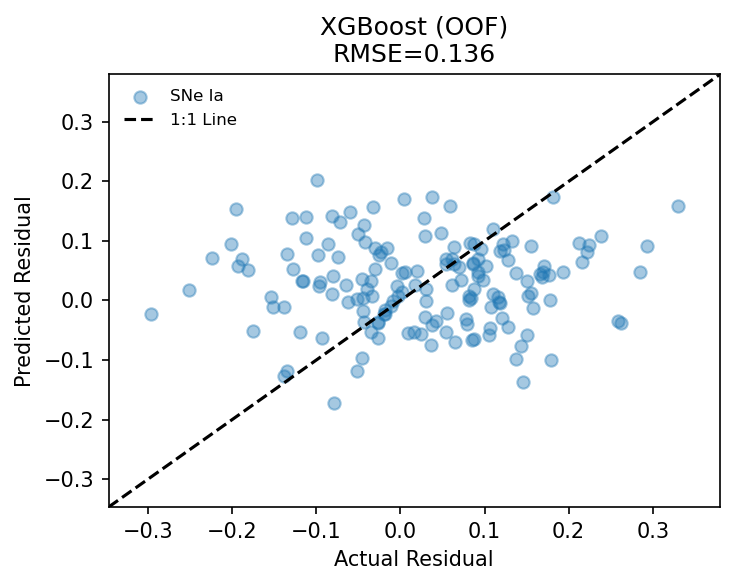

In [8]:
# keep only rows where we have OOF predictions
mask   = ~np.isnan(y_pred_oof)
y_true = y.to_numpy()[mask]
y_pred = y_pred_oof[mask]

# metrics
rmse = float(np.sqrt(((y_pred - y_true)**2).mean()))

# limits
lo = min(y_true.min(), y_pred.min()) - 0.05
hi = max(y_true.max(), y_pred.max()) + 0.05

# plot
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.scatter(y_true, y_pred, s=35, alpha=0.4, label="SNe Ia")

# 1:1 line only
ax.plot([lo, hi], [lo, hi], '--', lw=1.5, color='black', label='1:1 Line')

ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
ax.set_xlabel("Actual Residual")
ax.set_ylabel("Predicted Residual")
ax.set_title(f"XGBoost (OOF)\nRMSE={rmse:.3f}")
ax.legend(frameon=False, fontsize=8, loc="upper left")
plt.tight_layout()

